In [45]:
import xarray as xr
import numpy as np
import argparse
import os
import fdasrsf.curve_functions as curve_functions
import tqdm
import umap
#import umap.plot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import classify_style
import sklearn.model_selection as model_selection
import classify_style
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
def equalize_fraglet_numbers(dataset):
    style_array = np.array(dataset.style.values)
    # Figure out maximum number by style
    styles, counts = np.unique(style_array, return_counts=True)
    print(counts)
    num_per_style = np.min(counts)
    full_selection = []
    for s in styles:
        indices = np.argwhere(style_array == s).squeeze()
        selection = np.random.choice(indices, size=num_per_style, replace=False)
        full_selection.append(selection)
    full_selection = np.sort(np.concatenate(full_selection))
    return dataset.isel(fraglet_id =full_selection)

In [85]:
class args:
    min_area = 400
    min_periphery_factor = 5

fragment_fraglets = classify_style.read_fraglets("../netcdf/style-frags-merge/", args())
codebook_fraglets = classify_style.read_fraglets("../netcdf/codebook-augmented", args())

# Equalize number of fragments by style
codebook_fraglets = equalize_fraglet_numbers(codebook_fraglets)
classify_style.normalize_fraglets_simple(fragment_fraglets)
classify_style.normalize_fraglets_simple(codebook_fraglets)
# Get distribution of styles over classes


Reading fraglets images from ../netcdf/style-frags-merge/fraglets.nc
Read 136372 fraglets.
Remaining fraglets after filtering: 40449.
Reading fraglets images from ../netcdf/codebook-augmented/fraglets.nc
Read 50898 fraglets.
Remaining fraglets after filtering: 13126.
[1249 6372 5505]


In [86]:
print(np.unique(fragment_fraglets.style.values, return_counts=True))
print(np.unique(codebook_fraglets.style.values, return_counts=True))

(array(['Archaic', 'Hasmonean', 'Herodian'], dtype=object), array([13832, 12854, 13763]))
(array(['Archaic', 'Hasmonean', 'Herodian'], dtype=object), array([1249, 1249, 1249]))


In [87]:
#classify_style.get_srvf(fragment_fraglets)
#classify_style.get_srvf(codebook_fraglets)

In [88]:
full_label = codebook_fraglets['style'].astype('str').str.cat(
    codebook_fraglets['allograph'].astype('str')
).values
full_label_encoder = LabelEncoder()
codebook_fraglets['full_label'] = ('fraglet_id', full_label_encoder.fit_transform(full_label))

style_label = codebook_fraglets['style'].astype('str').values
style_label_encoder = LabelEncoder()
codebook_fraglets['style_label'] = ('fraglet_id', style_label_encoder.fit_transform(style_label))

allo_label = codebook_fraglets['allograph'].astype('str').values
allo_label_encoder = LabelEncoder()
codebook_fraglets['allo_label'] = ('fraglet_id', allo_label_encoder.fit_transform(allo_label))


In [89]:
img_train, img_test = model_selection.train_test_split(codebook_fraglets.img_id, train_size=0.75, stratify=codebook_fraglets.style)

In [90]:
train_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_train), drop=True)
test_ds = codebook_fraglets.where(codebook_fraglets.img_id.isin(img_test), drop=True)

/home/jeroen/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


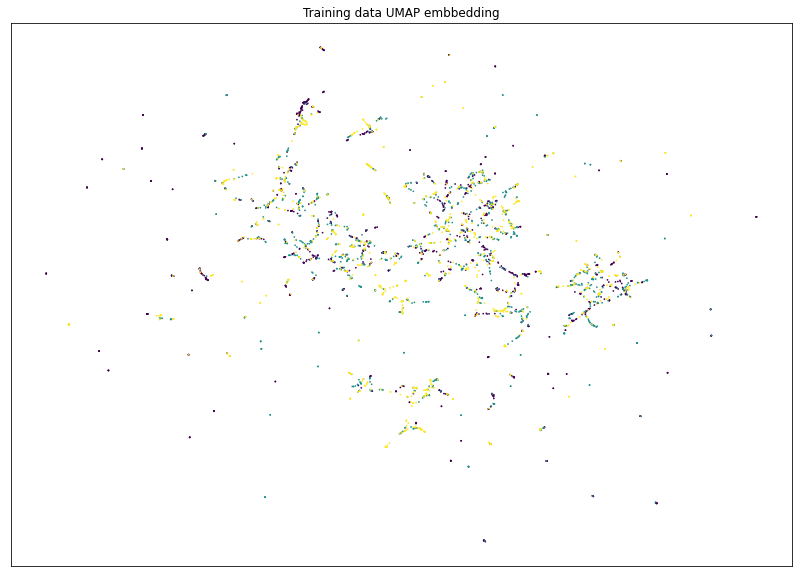

In [123]:
train_features = np.stack([train_ds['contour_norm'].values], axis = 2).reshape(-1,200)
feature_projection = umap.UMAP(
    min_dist=0.1,
    n_components=2,
    n_neighbors=5,#,
    metric='manhattan'
    #densmap=True,
)
train_embedding = feature_projection.fit_transform(train_features, y=train_ds.full_label)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=0.5, c=train_ds.style_label, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Training data UMAP embbedding');
plt.show()

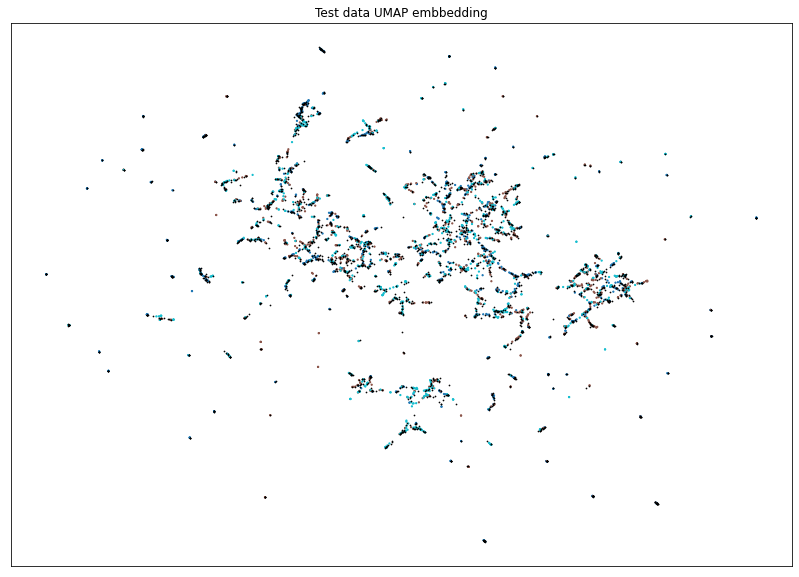

In [124]:
test_features = np.stack([test_ds['contour_norm'].values], axis = 2).reshape(-1,200)
test_embedding = feature_projection.transform(test_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=1.5, c=train_ds.style_label, alpha=1.0, cmap='tab10')
plt.scatter(*test_embedding[:,:2].T, s=0.5, alpha=1.0, c='k')
plt.setp(ax, xticks=[], yticks=[])
plt.title('Test data UMAP embbedding')
plt.show()

In [130]:
from sklearn.neighbors import KNeighborsClassifier
fraglet_style_knn = KNeighborsClassifier(n_neighbors=3)
fraglet_style_knn.fit(train_embedding, train_ds.style_label)
style_pred = fraglet_style_knn.predict(test_embedding)
print("Style prediction accuracy:", fraglet_style_knn.score(test_embedding, test_ds.style_label))


fraglet_full = KNeighborsClassifier(n_neighbors=10)
fraglet_full.fit(train_embedding, train_ds.full_label)
full_pred = fraglet_full.predict(test_embedding)
print("Full prediction accuracy: ", fraglet_full.score(test_embedding, test_ds.full_label))

fraglet_allo_knn = KNeighborsClassifier(n_neighbors=10)
fraglet_allo_knn.fit(train_embedding, train_ds.allo_label)
print("Allograph prediction accuracy:", fraglet_allo_knn.score(test_embedding, test_ds.allo_label))



Style prediction accuracy: 0.7711941659070192
Full prediction accuracy:  0.5264357338195077
Allograph prediction accuracy: 0.5806745670009116


In [131]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_ds.style_label, style_pred)

array([[904,  57,  45],
       [107, 395, 105],
       [104,  84, 393]])

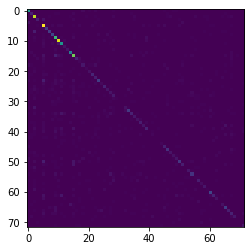

In [132]:
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(test_ds.full_label, full_pred))

# Classify the fragments

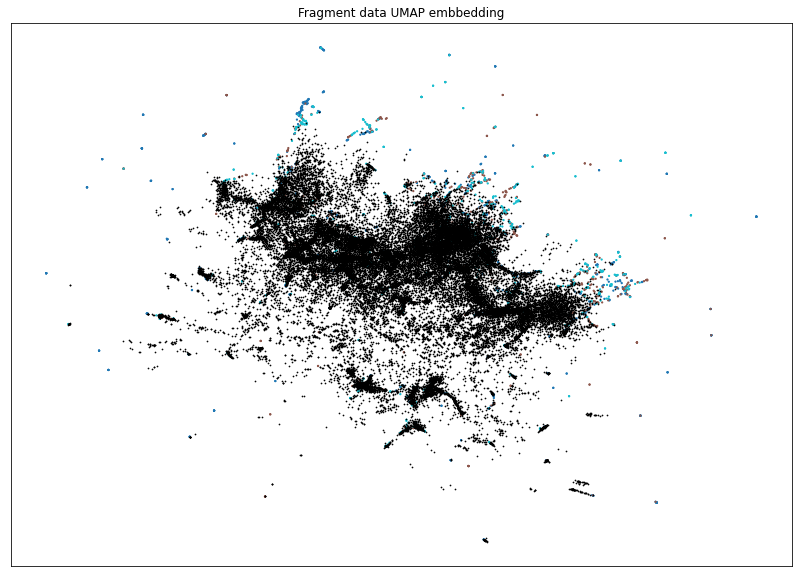

In [133]:
fragment_features = np.stack([fragment_fraglets['contour_norm'].values], axis = 2).reshape(-1,200)
fragment_embedding = feature_projection.transform(fragment_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*train_embedding[:,:2].T, s=1.5, c=train_ds.style_label, alpha=1.0, cmap='tab10')
plt.scatter(*fragment_embedding[:,:2].T, s=0.5, alpha=1.0, c='k')
plt.setp(ax, xticks=[], yticks=[])
plt.title('Fragment data UMAP embbedding');
plt.show()

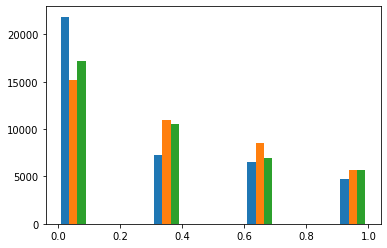

In [135]:
frag_prob = fraglet_style_knn.predict_proba(fragment_embedding)
plt.hist(frag_prob)
frag_prediction = fraglet_style_knn.predict(fragment_embedding)
frag_prob /= np.sum(frag_prob, axis = 0)

In [136]:
id_str = np.array(fragment_fraglets.img_id.values, dtype='str')
style_counts = np.unique(np.array(train_ds.style.values, dtype='str'), return_counts=True)[1]
style_counts = style_counts / np.sum(style_counts)
points = []
for img_id in np.unique(id_str):
    p = frag_prob[id_str == img_id]
    pred = frag_prediction[id_str == img_id]
    #print(np.unique(pred, return_counts=True))
    p_sum = np.sum(p, axis = 0) #/ style_counts
    #print(np.argmax(p_sum))
    style = style_label_encoder.inverse_transform([np.argmax(p_sum)])
    points.append(p_sum)
    print(img_id, style, p_sum)

style_fragments_Archaic_0 ['Archaic'] [0.08213884 0.07698787 0.08170729]
style_fragments_Archaic_1 ['Hasmonean'] [0.09148329 0.09669482 0.08550875]
style_fragments_Archaic_2 ['Herodian'] [0.07608225 0.07485979 0.08538845]
style_fragments_Archaic_3 ['Hasmonean'] [0.09234851 0.09336969 0.08933426]
style_fragments_Hasmonean_0 ['Archaic'] [0.07887982 0.07599033 0.07424873]
style_fragments_Hasmonean_1 ['Hasmonean'] [0.08011998 0.08481302 0.08009528]
style_fragments_Hasmonean_2 ['Archaic'] [0.07720705 0.07667753 0.0718668 ]
style_fragments_Hasmonean_3 ['Hasmonean'] [0.08329248 0.08656425 0.08334336]
style_fragments_Herodian_0 ['Herodian'] [0.05580711 0.05634989 0.0616173 ]
style_fragments_Herodian_1 ['Herodian'] [0.11063363 0.11283279 0.11438058]
style_fragments_Herodian_2 ['Archaic'] [0.11669022 0.11172441 0.11240767]
style_fragments_Herodian_3 ['Herodian'] [0.05531682 0.0531356  0.06010153]


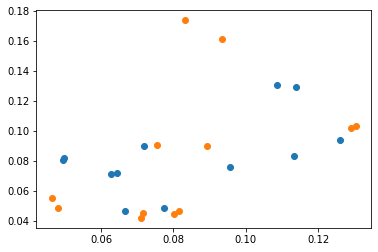

In [18]:
p = np.array(points)
plt.scatter(*p[:,:2].T)
plt.scatter(*p[:,1:].T)

# Constructing a codebook with k-means in the learned metric

In [134]:
from sklearn import cluster

In [351]:
codebook_kmeans = cluster.KMeans(n_clusters=300)
codebook_labels = codebook_kmeans.fit_predict(train_embedding)

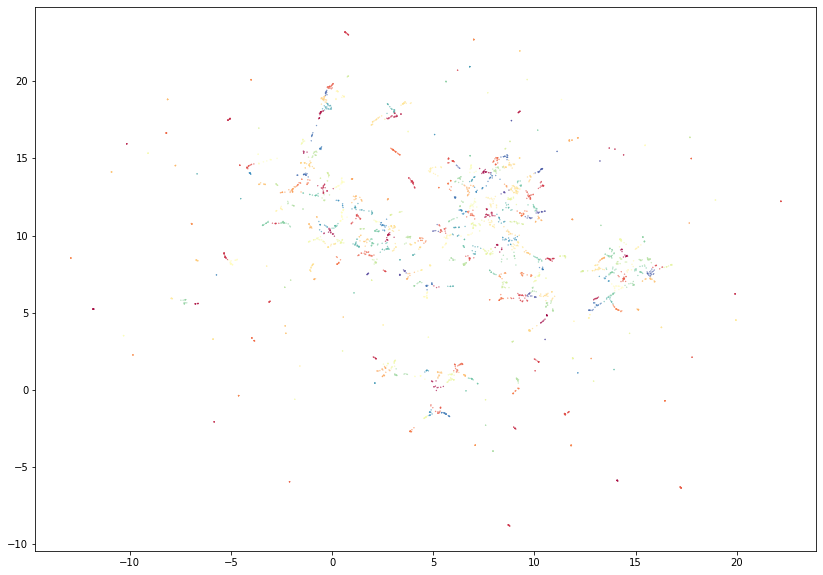

In [352]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(train_embedding[:, 0], train_embedding[:, 1], c=codebook_labels, s=0.1, cmap='Spectral')

In [375]:
# Classify the fragment embedding using this clustering
fragment_encoding = codebook_kmeans.predict(fragment_embedding)

# Is there a difference between the fragments of the different styles?
id_str = np.array(fragment_fraglets.img_id.values, dtype='str')

images = np.unique(id_str)

density = np.zeros(shape = (len(images), codebook_kmeans.n_clusters))
for i, img_id in enumerate(images):
    encoding = fragment_encoding[id_str == img_id]
    # Count freqency of each codebook point
    density[i] = np.bincount(encoding, minlength=codebook_kmeans.n_clusters)
    # Normalize
    density[i] /= np.sum(density[i])


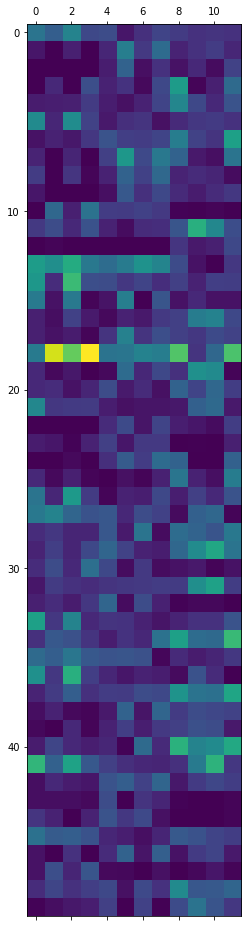

In [376]:
from sklearn import feature_selection
density_th = np.maximum(density, 0.001)
chi2score, pval = feature_selection.chi2(density, [0,0,0,0,1,1,1,1,2,2,2,2])
chi2reducer = feature_selection.SelectKBest(score_func = feature_selection.chi2, k=50)
selected_codepoints = chi2reducer.fit_transform(density_th, [0,0,0,0,1,1,1,1,2,2,2,2])
plt.matshow(selected_codepoints.T)

0.0005411255411255411
0.02480452952278242


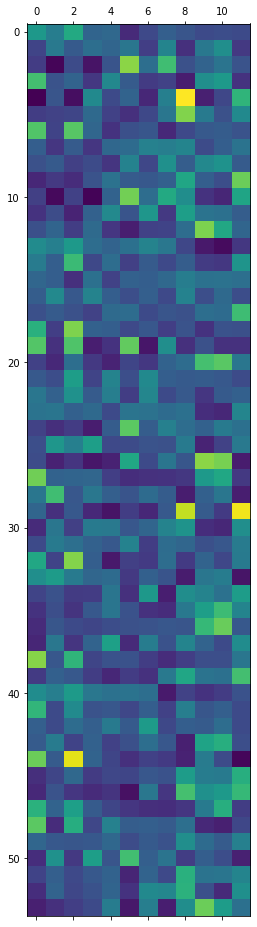

In [377]:
print(np.min(density.max(axis = 0)))
print(np.max(density.max(axis = 0)))
higher_density = density[:,density.max(axis = 0) > 0.01]
higher_density = np.maximum(higher_density, 0.0001)
higher_density /=  np.sum(higher_density, axis = 0)
plt.matshow(higher_density.T, aspect='auto')

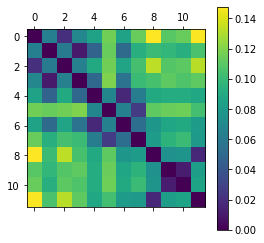

Text(0.5, 1.0, 'Shortest Chi-squared distance to class using codebook pdf')

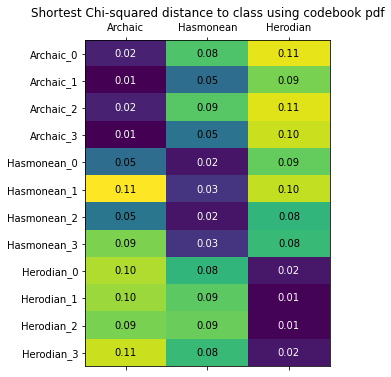

In [378]:


# Now we want to compare the intra-class and inter-class Chi-squares distances
from scipy.stats import chisquare
distances = np.zeros((12, 12))
for i in range(12):
    for j in range(12):
        #print(density[i])
        #print(i, j, chisquare(density[i], f_exp=density[j]))
        a = selected_codepoints[i]
        b =  selected_codepoints[j]
        chisq = np.sum((a - b)**2 / (a + b))
        distances[i, j] = chisq
        #print(i, j, chisq)
# Find nearest class for each fragment
min_class_dist = np.zeros((12, 3))
for i in range(12):
    dist = np.copy(distances[i])
    dist[i] = 100
    for n_c in range(3):
        min_class_dist[i, n_c] = np.min(dist[n_c * 4 : (n_c + 1) * 4])
plt.matshow(distances)
plt.colorbar()
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.matshow(min_class_dist, aspect = 1/3)
#ax[0] = plt.gca()
ax.set_xticks(np.arange(len(style_labels)))
ax.set_xticklabels(style_labels)
ax.set_yticks(np.arange(len(frag_labels)))
ax.set_yticklabels(np.char.lstrip(frag_labels, 'style_fragments_'))
#ax[1].colorbar(label = "Leave-one-out Chi-squares distance")
for i in range(len(style_labels)):
    for j in range(len(frag_labels)):
        c = 'w' if (j // 4 == i) else 'k'
        text = ax.text(i, j, "{:.2f}".format(min_class_dist[j, i]),
                       ha="center", va="center", color=c)
frag_labels = np.unique(id_str)
style_labels = ['Archaic', 'Hasmonean', 'Herodian']
plt.title("Shortest Chi-squared distance to class using codebook pdf")
#plt.savefig("../plots/style_classification_chisq.eps")
#plt.savefig("../plots/style_classification_chisq.png")

# Now classify by leave-one-out cross-validation
from scipy.stats import hmean
style_distances = np.zeros((12, 3))
for i in range(12):
    class_density = np.copy(selected_codepoints)
    mask = np.zeros_like(class_density)
    mask[i] = 1
    # mask
    class_density = np.ma.masked_array(class_density, mask=mask)
    #class_density[i] = np.nan
#     print(np.ptp(class_density))
    class_density = class_density.reshape(3, 4, -1)#.sum(axis = 1)
    #class_density = class_density / np.sum(class_density, axis = 1)[:,np.newaxis]
#     plt.show()
    class_density = hmean(class_density, axis = 1)
    class_density = class_density / np.sum(class_density, axis = 1)[:,np.newaxis]
    
#     print(class_density.shape, higher_density.shape, np.sum(class_density, axis = 1))
#     plt.imshow(class_density.T, aspect='auto', interpolation='none')
#     plt.show()
    for j in range(3):
        
        #print(density[i])
        #print(i, j, chisquare(density[i], f_exp=density[j]))
        a = selected_codepoints[i] / np.sum(selected_codepoints[i])
        #print(a)
        b =  class_density[j]
#         print(np.sum(a), np.sum(b))
#         plt.plot(a / a.sum())
#         plt.plot(b)
#         plt.show()
        chisq = np.sum((a - b)**2 / (a + b))
        style_distances[i, j] = chisq
#         print(i, j, chisq)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.matshow(style_distances, aspect = 1/3)
#ax[0] = plt.gca()
ax.set_xticks(np.arange(len(style_labels)))
ax.set_xticklabels(style_labels)
ax.set_yticks(np.arange(len(frag_labels)))
ax.set_yticklabels(np.char.lstrip(frag_labels, 'style_fragments_'))
#ax[1].colorbar(label = "Leave-one-out Chi-squares distance")
dist_range = np.ptp(style_distances)
min_dist = np.min(style_distances)
for i in range(len(style_labels)):
    for j in range(len(frag_labels)):
        c = 'w' if ((style_distances[j, i] - min_dist) / dist_range < 0.5) else 'k'
        text = ax.text(i, j, "{:.3f}".format(style_distances[j, i]),
                       ha="center", va="center", color=c)
frag_labels = np.unique(id_str)
style_labels = ['Archaic', 'Hasmonean', 'Herodian']
plt.title("Chi-squared distance to harmonic mean of style pdf")
plt.savefig("../plots/style_classification_chisq_hmean.eps")
plt.savefig("../plots/style_classification_chisq_hmean.png")

# Combined embedding

In [ ]:
fragment_features = np.stack([fragment_fraglets['square_root_velocity'].values, fragment_fraglets['contour_norm'].values], axis = 2).reshape(-1,400)
train_features = np.stack([train_ds['square_root_velocity'].values, train_ds['contour_norm'].values], axis = 2).reshape(-1,400)
combined_features = np.concatenate([
    fragment_features,
    train_features
], axis = 0)

combined_labels = np.concatenate([
    np.repeat(-1, fragment_features.shape[0]),
    train_ds.style_label.astype('int') + 1
])

feature_projection = umap.UMAP(target_metric='categorical', target_weight=0.75)
combined_embedding = feature_projection.fit_transform(combined_features, y=combined_labels)
#feature_projection.transform(combined_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*combined_embedding.T, s=0.5, c=combined_labels, alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title('Combined UMAP embbedding');
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

test_embedding = feature_projection.transform(test_features)
train_embedding = feature_projection.transform(train_features)
fraglet_style_knn = KNeighborsClassifier(n_neighbors=3)
fraglet_style_knn.fit(train_embedding, train_ds.style_label)
style_pred = fraglet_style_knn.predict(test_embedding)
print("Style prediction accuracy:", fraglet_style_knn.score(test_embedding, test_ds.style_label))


fraglet_full = KNeighborsClassifier(n_neighbors=10)
fraglet_full.fit(train_embedding, train_ds.full_label)
full_pred = fraglet_full.predict(test_embedding)
print("Full prediction accuracy: ", fraglet_full.score(test_embedding, test_ds.full_label))

fraglet_allo_knn = KNeighborsClassifier(n_neighbors=10)
fraglet_allo_knn.fit(train_embedding, train_ds.allo_label)
print("Allograph prediction accuracy:", fraglet_allo_knn.score(test_embedding, test_ds.allo_label))



In [ ]:
fragment_embedding = feature_projection.transform(fragment_features)
frag_prob = fraglet_style_knn.predict_proba(fragment_embedding)
frag_prob /= np.sum(frag_prob, axis = 0)

In [ ]:
id_str = np.array(fragment_fraglets.img_id.values, dtype='str')
style_counts = np.unique(np.array(train_ds.style.values, dtype='str'), return_counts=True)[1]
style_counts = style_counts / np.sum(style_counts)
points = []
for img_id in np.unique(id_str):
    p = frag_prob[id_str == img_id]
    p_sum = np.sum(p, axis = 0) #/ style_counts
    #print(np.argmax(p_sum))
    style = style_label_encoder.inverse_transform([np.argmax(p_sum)])
    points.append(p_sum)
    print(img_id, style, p_sum)